In [1]:
%matplotlib widget
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../../

import pylib.mix as mix
import cvxpy as cp
import pylib.qucf_read as qucf_r
import pylib.measurement as mse

from matplotlib import colors

colors_ = ["blue", "red", "green", "gray", "black"]

6663
/media/work/docs/codes/QuCF/scripts-py


In [2]:
for i in range(100):
    plt.close()

In [3]:
# -----------------------------------------------------
# --- Canonical coordinate and some constants ---
# -----------------------------------------------------
xmax_, Nx_ = 4.0, 1001

x_ = np.linspace(-xmax_, xmax_, Nx_)
dx_ = np.diff(x_)[0]

# --- Planck constant: h / 2pi, h = 6.6261e−34 J*s ---
hp_ = 1.0 

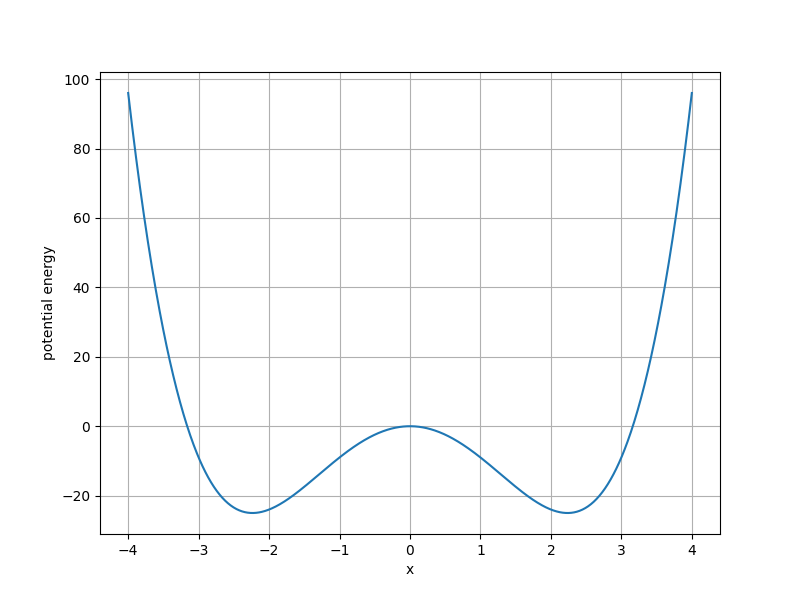

In [4]:
# -----------------------------------------------------
# --- Double-well potential ---
# -----------------------------------------------------
def double_well(x, dx, Nx, Ca, w, Cq):
    H = np.zeros((Nx, Nx))
    V = np.zeros(Nx) 

    coef0 = hp_**2 / (2.*Ca * dx**2)
    coef1 = 0.5 * Ca * w**2 

    V_func = lambda x: - coef1 * x**2 + Cq * x**4

    for ir in range(Nx):
        # --- Potential ---
        V[ir] = V_func(x[ir])
        # coef1 * x[ir] * x[ir]

        # --- Hamiltonian ---
        if ir == 0:
            H[ir, Nx-1] = -coef0
        else:
            H[ir, ir-1] = -coef0

        if ir == (Nx-1):
            H[ir, 0] = -coef0
        else:
            H[ir, ir+1] = -coef0
        H[ir, ir] = 2. * coef0 + V[ir]

    return H, V, V_func, "harm-osc"
# ---------------------------------------------------------------
Ca_ = 20.0 # capacitance
w_  = 1.0 # frequency, 1/sqrt(LC)
Cq_ = 1.0
H_, V_, V_func_, str_H_ = double_well(x_, dx_, Nx_, Ca_, w_, Cq_)

# --- Plot potential ---
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(x_, V_)
ax.set_xlabel("x")
ax.set_ylabel("potential energy")
ax.grid()
del ax, fig

In [5]:
# ------------------------------------------------------------
# --- Compute eigenvalues and eigenvectors ---
# ------------------------------------------------------------
def compute_eig(H):
    eigVals, eigVecs = np.linalg.eig(H)

    eigVals_sorted = np.sort(eigVals)
    ids_sort = np.argsort(eigVals)

    eigVecs_sorted = eigVecs[:,ids_sort]

    return eigVals_sorted, eigVecs_sorted
# ------------------------------------------------------------
def compute_anharmonicity(eigVals):
    Nx = len(eigVals)
    dw = np.zeros(Nx-1)
    for ix in range(Nx-1):
        dw[ix] = eigVals[ix+1] - eigVals[ix]

    anh = np.zeros(Nx-2)
    for ix in range(Nx-2):
        anh[ix] = dw[ix+1] - dw[ix]    
    return dw, anh
# ------------------------------------------------------------
eigVals_sorted_, eigVecs_sorted_ = compute_eig(H_)
dw_, anh_ = compute_anharmonicity(eigVals_sorted_)
print("Done")

Done


In [6]:
# ------------------------------------------------------------
# --- Print eigenvalues and anharmonicity ---
# ------------------------------------------------------------
def print_eigvals_via_diag_matrix(M, eigVecs_sorted, N_first_eigvals, ff_print):

    # --- matrix diagonalization ---
    Pinv = np.linalg.inv(eigVecs_sorted)
    M_diagonalized = np.dot(np.dot(Pinv, M), eigVecs_sorted)

    # --- extract elements on the main diagonal (eigenvalues) ---
    H_diag_diag = np.diag(M_diagonalized)

    # --- print several first diagonal elements ---
    mix.print_array(H_diag_diag[:N_first_eigvals], ff=ff_print, n_in_row = N_first_eigvals)
    return
# -------------------------------------------------------------------
Ne_print = 20
ff_print = [6, 3, "f"]

print("--- {:d} first eigenvalues ---".format(Ne_print))
mix.print_array(eigVals_sorted_[:Ne_print], ff=ff_print, n_in_row = Ne_print)

print("\n--- {:d} first eigenvalues (via diagonalization) ---".format(Ne_print))
print_eigvals_via_diag_matrix(H_, eigVecs_sorted_, Ne_print, ff_print)

print("\n--- energy differences of first {:d} eigenvalues ---".format(Ne_print))
mix.print_array(dw_[:Ne_print], ff=ff_print, n_in_row = Ne_print)

print("\n--- anharmonicity of first {:d} eigenvalues ---".format(Ne_print))
mix.print_array(anh_[:Ne_print], ff=[12, 3, "e"], n_in_row = Ne_print)

del Ne_print, ff_print

--- 20 first eigenvalues ---
-24.295 -24.295 -22.897 -22.897 -21.514 -21.514 -20.148 -20.148 -18.799 -18.799 -17.468 -17.468 -16.155 -16.155 -14.861 -14.861 -13.588 -13.588 -12.335 -12.335 

--- 20 first eigenvalues (via diagonalization) ---
-24.295 -24.295 -22.897 -22.897 -21.514 -21.514 -20.148 -20.148 -18.799 -18.799 -17.468 -17.468 -16.155 -16.155 -14.861 -14.861 -13.588 -13.588 -12.335 -12.335 

--- energy differences of first 20 eigenvalues ---
 0.000  1.399  0.000  1.383  0.000  1.366  0.000  1.349  0.000  1.331  0.000  1.313  0.000  1.294  0.000  1.274  0.000  1.253  0.000  1.231 

--- anharmonicity of first 20 eigenvalues ---
   1.399e+00   -1.399e+00    1.383e+00   -1.383e+00    1.366e+00   -1.366e+00    1.349e+00   -1.349e+00    1.331e+00   -1.331e+00    1.313e+00   -1.313e+00    1.294e+00   -1.294e+00    1.274e+00   -1.274e+00    1.253e+00   -1.253e+00    1.231e+00   -1.231e+00 


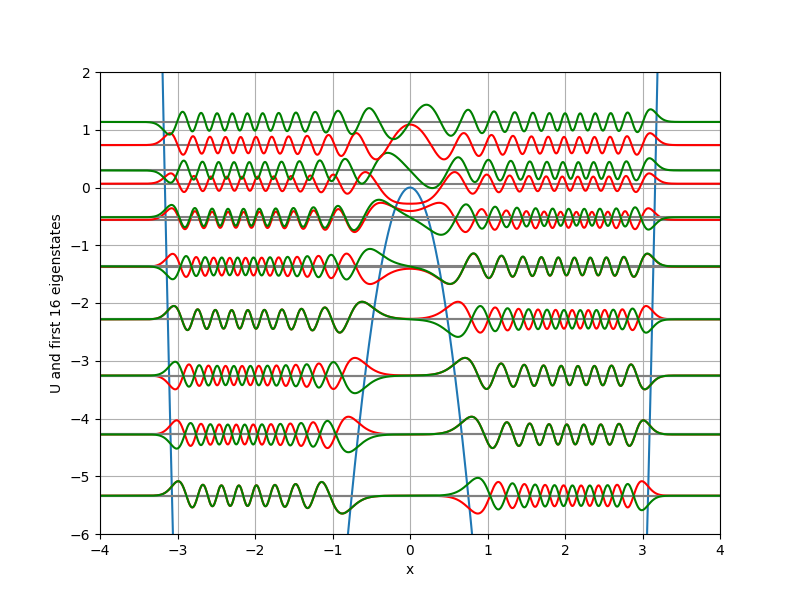

In [7]:
# ------------------------------------------------------------
# --- Plot eigenvalues, anharmonicity and eigenvectors ---
# ------------------------------------------------------------
def plot_eig_anh(id_eig_start, id_eig_end, resc_eigv = 4.0, flag_eigstates = True, ymin = -25):
    N_eig = id_eig_end - id_eig_start

    # --- Plot eigenvalues and eigenstates ---
    if flag_eigstates:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111)
        ax.plot(x_, V_, "-")
        for ii in range(id_eig_start, id_eig_end):
            ax.hlines(eigVals_sorted_[ii], -xmax_, xmax_, color="gray")

            color_plot = "green"
            if ii % 2 == 0:
                color_plot = "red"

            eig_vec = resc_eigv * np.array(eigVecs_sorted_[:,ii]) 
            eig_vec += eigVals_sorted_[ii] * np.ones(Nx_)
            ax.plot(x_, eig_vec, "-", color = color_plot)
        ax.set_xlim([-4, 4])
        ax.set_ylim([ymin, 2])
        ax.set_xlabel("x")
        ax.set_ylabel("U and first {:d} eigenstates".format(N_eig))
        ax.grid()

    # # --- Plot energy-differences and anharmonicities ---
    # fig = plt.figure(figsize=(8, 6))
    # ax = fig.add_subplot(211)
    # ax.plot(range(id_eig_start,id_eig_end), dw_[id_eig_start:id_eig_end])
    # ax.set_xlabel("i")
    # ax.set_ylabel("dw")
    # ax.grid()

    # ax = fig.add_subplot(212)
    # ax.plot(range(id_eig_start,id_eig_end), anh_[id_eig_start:id_eig_end])
    # ax.set_xlabel("i")
    # ax.set_ylabel("anharmonicity")
    # ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
    # ax.grid()
    return
# ----------------------------------------------------
id_eig_start, N_eig_half, resc_eigv, ymin = 30, 46, 4.0, -6
plot_eig_anh(id_eig_start, N_eig_half, resc_eigv, True, ymin)

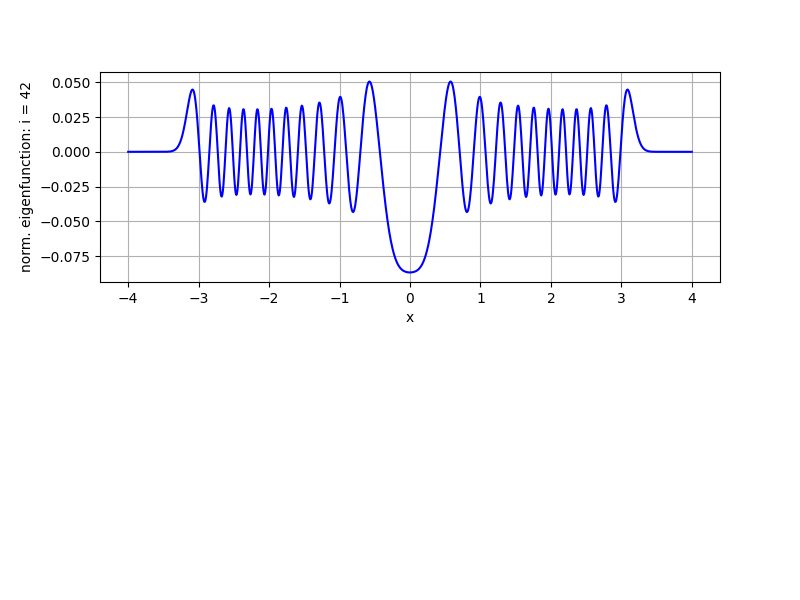

In [72]:
# ------------------------------------------------------------------
# --- Compare numerically computed and analytical eigenfunctions ---
# ------------------------------------------------------------------
import math
def plot_eigfunction(id_to_plot):

    # --- num. function ---
    eigf_num = np.array(eigVecs_sorted_[:,id_to_plot])

    # --- Plotting ---
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(211)
    ax.plot(x_, eigf_num, "-b")
    ax.set_xlabel("x")
    ax.set_ylabel("norm. eigenfunction: i = {:d}".format(id_to_plot))
    ax.grid()
    return
# --------------------------------------------------------------------------
plot_eigfunction(id_to_plot = 42)